In [151]:
import pandas as pd
import config
import pickle
import matplotlib.pyplot as plt
import numpy as np

output_path = config.CONFIG_OUTPUT_PATH["final_outputs"]


In [152]:
# define paths
metrics_darts = config.CONFIG_OUTPUT_PATH["darts"] / "darts_metrics.csv"
metrics_path_tl_itransformer = config.CONFIG_OUTPUT_PATH["itransformer"] / "itransformer_results_transfer_learning.csv"
metrics_path_baseline_itransformer = config.CONFIG_OUTPUT_PATH["itransformer"] / "itransformer_results_baseline.csv"
metrics_timegpt = config.CONFIG_OUTPUT_PATH["TimeGPT"] / "timegpt_results.csv"


# read csv
metrics_darts = pd.read_csv(metrics_darts)
metrics_tl_itransformer = pd.read_csv(metrics_path_tl_itransformer)
metrics_baseline_itransformer = pd.read_csv(metrics_path_baseline_itransformer)
metrics_timegpt = pd.read_csv(metrics_timegpt, index_col=[0])

# split "setup" into source/target column
metrics_tl_itransformer[['Source', 'Target']] = metrics_tl_itransformer['Setup'].str.split('_to_', expand=True)
metrics_tl_itransformer = metrics_tl_itransformer.drop(columns=['Setup'])
metrics_darts[['Source', 'Target']] = metrics_darts['Setup'].str.split('_to_', expand=True)
metrics_darts = metrics_darts.drop(columns=['Setup'])

# drop nan
metrics_baseline_itransformer = metrics_baseline_itransformer.dropna()
metrics_tl_itransformer = metrics_tl_itransformer.dropna()

# split darts df into baseline/tl
metrics_darts_baseline = metrics_darts[metrics_darts['Learning_scenario'].isin(['full_training', 'four_weeks_training'])]
metrics_darts_baseline = metrics_darts_baseline.drop(columns=["Source"])
metrics_darts_baseline = metrics_darts_baseline.drop_duplicates(subset=['Target', 'Learning_scenario', 'Metric'])
metrics_darts_tl = metrics_darts[metrics_darts['Learning_scenario'].isin(['Zero-Shot', 'four_weeks_tl', 'full_tl'])]

# sort baseline dataframes the same way and merge
baseline_index = ["Target", "Learning_scenario", "Metric"]
metrics_baseline_itransformer = metrics_baseline_itransformer.set_index(baseline_index)
metrics_darts_baseline = metrics_darts_baseline.set_index(baseline_index)

metrics_darts_baseline = metrics_darts_baseline.sort_index(level=baseline_index)
metrics_baseline_itransformer = metrics_baseline_itransformer.sort_index(level=baseline_index)

#metrics_baseline_itransformer
metrics_darts_baseline["iTransformer"] = metrics_baseline_itransformer["iTransformer"]
baseline_metrics_dl = metrics_darts_baseline

# append itransformer metrics to darts df
tl_index = ["Target", "Source", "Learning_scenario", "Metric"]
metrics_darts_tl = metrics_darts_tl.set_index(tl_index)
metrics_tl_itransformer = metrics_tl_itransformer.set_index(tl_index)
metrics_darts_tl["iTransformer"] = metrics_tl_itransformer["iTransformer"]
tl_metrics = metrics_darts_tl
tl_metrics = tl_metrics.sort_index(level=["Target"])

# reshape timegpt results
metrics_timegpt = metrics_timegpt.transpose()
metrics_timegpt = metrics_timegpt.stack()
metrics_timegpt = metrics_timegpt.reset_index()
metrics_timegpt.columns = ['Metric', 'Target', 'TimeGPT']

df = tl_metrics.reset_index()
timegpt_df = metrics_timegpt
zero_shot_df = df[df['Learning_scenario'] == 'Zero-Shot']

# Merge the TimeGPT values with the zero-shot DataFrame on Target and Metric
zero_shot_merged = zero_shot_df.merge(timegpt_df, on=['Target', 'Metric'], how='left')

# Combine the results back into the original DataFrame
tl_metrics = df.merge(zero_shot_merged[['Target', 'Source', 'Learning_scenario', 'Metric', 'TimeGPT']],\
                       on=['Target', 'Source', 'Learning_scenario', 'Metric'], how='left')

baseline_metrics_dl = baseline_metrics_dl.reset_index()
baseline_metrics_dl["Source"] = baseline_metrics_dl["Target"]

# split into target datasets
tmp = pd.concat([tl_metrics, baseline_metrics_dl])

# nbeats is dropped because in many cases it does not manage to learn meaningfull information
Bavaria = tmp[tmp["Target"] == "Bavaria"]
Bavaria = Bavaria.drop(columns=(["Target"]))
try: Bavaria = Bavaria.drop(columns=(["NBEATS"]))
except: print("NBEATS model was not trained")
ELD = tmp[tmp["Target"] == "ELD"]
ELD = ELD.drop(columns=(["Target"]))
try: ELD = ELD.drop(columns=(["NBEATS"]))
except: print("Nbeats model was not trained")
GP2 = tmp[tmp["Target"] == "GP2"]
GP2 = GP2.drop(columns=(["Target"]))
try: GP2 = GP2.drop(columns=(["NBEATS"]))
except: print("Nbeats model was not traiend")

target_dataset_metrics = {"Bavaria": Bavaria,
                        "ELD" : ELD,
                        "GP2" : GP2
            }

# load and reshape arima results
preds_dict = {
"ELD" : config.CONFIG_OUTPUT_PATH["arima"] / 'arima_electricity_predictionsfull.pkl',
"Bavaria" : config.CONFIG_OUTPUT_PATH["arima"] / 'arima_bavaria_predictionsfull.pkl',
"GP2" : config.CONFIG_OUTPUT_PATH["arima"] / 'arima_genome_project_predictionsfull.pkl',
    }

arima_results = pd.DataFrame(index=["MSE", "MAE"])

for key, value in preds_dict.items():
    with open(value, 'rb') as file:
        preds = pickle.load(file)

    mse_preds = [element[0] for element in preds]
    mse = sum(mse_preds) / len(mse_preds)

    mae_preds = [element[1] for element in preds]
    mae = sum(mae_preds) / len(mae_preds)
    arima_results[key] = [mse, mae]
arima_results = arima_results.transpose()
arima_results.to_csv(output_path / "arima_results.csv")


NBEATS model was not trained
Nbeats model was not trained
Nbeats model was not traiend


In [153]:
def calc_metrics(dataset, target="Bavaria", source_1="GP2", source_2="ELD"):
    """Calculate all 3 target dataset metrics using MSE"""
    
    dataset = dataset[dataset["Metric"] == "MSE"]
    dataset = dataset.drop(columns=["Metric"])
    dataset = dataset.set_index(["Source", "Learning_scenario"])
    dataset.loc[(target, "full_training"), "Mean MSE"] = dataset.loc[(target, "full_training"), :].mean()
    dataset.loc[(target, "four_weeks_training"), "Mean MSE"] = dataset.loc[(target, "four_weeks_training"), :].mean()
    dataset.loc[(source_1, "full_tl"), "Mean MSE"] = dataset.loc[(source_1, "full_tl"), :].mean()
    dataset.loc[(source_2, "full_tl"), "Mean MSE"] = dataset.loc[(source_2, "full_tl"), :].mean()
    dataset.loc[(source_1, "Zero-Shot"), "Mean MSE"] = dataset.loc[(source_1, "Zero-Shot"), :].mean()
    dataset.loc[(source_2, "Zero-Shot"), "Mean MSE"] = dataset.loc[(source_2, "Zero-Shot"), :].mean()
    dataset.loc[(source_1, "four_weeks_tl"), "Mean MSE"] = dataset.loc[(source_1, "four_weeks_tl"), :].mean()
    dataset.loc[(source_2, "four_weeks_tl"), "Mean MSE"] = dataset.loc[(source_2, "four_weeks_tl"), :].mean()

    for i in dataset.columns:
        if "Bavaria" in [source_1, source_2]:
            dataset.loc[("Overall mean", "All experiments"),i] =  dataset[i][1:].mean()
        else:
            dataset.loc[("Overall mean", "All experiments"),i] =  dataset[i][:].mean()

    return dataset


target_dataset_metrics["Bavaria_mse"] = calc_metrics(target_dataset_metrics["Bavaria"], "Bavaria", "GP2", "ELD")    
target_dataset_metrics["GP2_mse"] = calc_metrics(target_dataset_metrics["GP2"], "GP2", "Bavaria", "ELD")                   
target_dataset_metrics["ELD_mse"] = calc_metrics(target_dataset_metrics["ELD"], "ELD", "GP2", "Bavaria")     

for key, value in target_dataset_metrics.items():
    value.to_csv(output_path / f"{key}_target_results.csv")


# scale bavaria dataframe for better visualization
def scale_floats(x):
    try:
        # Check if the element is a float
        return x * 10**3 if isinstance(x, float) else x
    except:
        return x

# Apply the function to each element of the DataFrame
scaled_df_mse = target_dataset_metrics["Bavaria_mse"].applymap(scale_floats)
scaled_df_mse.to_csv(output_path / "Bavaria_mse_target_scaled_results.csv")

scaled_df = target_dataset_metrics["Bavaria"].applymap(scale_floats)
scaled_df.to_csv(output_path / "Bavaria_target_scaled_results.csv")

# Presentation

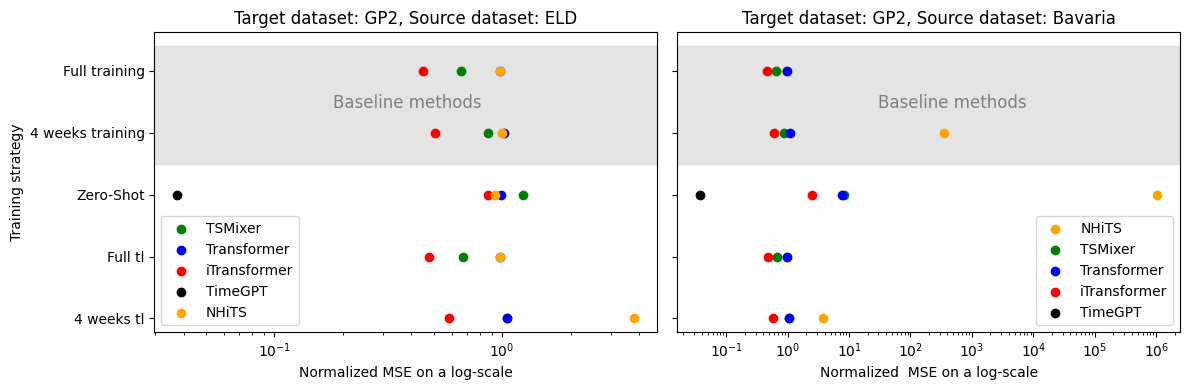

In [190]:
# create 2 scatterplot per target dataset containing all training-strategies, models, source datasets

def create_source_dataset_metrics(model, target, source):
    return_dict = {}
    baseline_values = list(target_dataset_metrics[f"{target}_mse"][model][target].values)

    for key in source.keys():
        return_dict[key] =  target_dataset_metrics[f"{target}_mse"][model][key].values
        return_dict[key] = baseline_values + list(return_dict[key])
    return return_dict


def visualize(target_dataset, text_x_1, text_x_2):
    x = ["4 weeks tl", "Full tl", "Zero-Shot", "4 weeks training", "Full training"]
    datasets_dict = {"GP2" : None, "ELD": None, "Bavaria": None}
    source = {key: value for key, value in datasets_dict.items() if key != target_dataset}

    y_nhits = create_source_dataset_metrics("NHiTS", target_dataset, source)
    y_transformer = create_source_dataset_metrics("Transformer", target_dataset, source)
    y_itransformer = create_source_dataset_metrics("iTransformer", target_dataset, source)
    y_tsmixer = create_source_dataset_metrics("TSMixer", target_dataset, source)
    y_timegpt = [np.nan, np.nan] + [target_dataset_metrics[target_dataset]["TimeGPT"].values[0]] + [np.nan, np.nan]

    # Create a figure and axis
    # Plot multiple line
    key_1, key_2 = source.keys()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    ax1.axhspan(2.5, 4.4, color='lightgray', alpha=0.6)
    ax2.axhspan(2.5, 4.4, color='lightgray', alpha=0.6)

    ax1.text(text_x_1, 3.4, 'Baseline methods', fontsize=12, color='grey')
    ax2.text(text_x_2, 3.4, 'Baseline methods', fontsize=12, color='grey')
    #else:
     #   ax1.text(0.1, 3.4, 'Baseline methods', fontsize=12, color='grey')
      #  ax2.text(0.1, 3.4, 'Baseline methods', fontsize=12, color='grey')

    ax2.set_xscale('log')
    ax1.set_xscale('log')

    ax1.scatter(y_tsmixer[key_1], x,label="TSMixer", marker='o', color="green")
    ax1.scatter(y_transformer[key_1], x, label="Transformer", marker='o', color="blue")
    ax1.scatter(y_itransformer[key_1], x, label="iTransformer", marker='o', color="red")
    ax1.scatter(y_timegpt, x, label="TimeGPT", marker='o', color="black")
    ax1.scatter(y_nhits[key_1], x, label="NHiTS", marker='o', color="orange")


    # Add a title and labels
    ax1.set_title(f'Target dataset: {target_dataset}, Source dataset: {key_1}')
    ax1.set_ylabel('Training strategy')
    ax1.set_xlabel('Normalized MSE on a log-scale')

    # Add a legend
    ax1.legend()

    # second source dataset
    ax2.scatter(y_nhits[key_2], x, label="NHiTS", marker='o', color="orange")
    ax2.scatter(y_tsmixer[key_2], x,label="TSMixer", marker='o', color="green")
    ax2.scatter(y_transformer[key_2], x, label="Transformer", marker='o', color="blue")
    ax2.scatter(y_itransformer[key_2], x, label="iTransformer", marker='o', color="red")
    ax2.scatter(y_timegpt, x, label="TimeGPT", marker='o', color="black")


    # Add a title and labels
    ax2.set_title(f'Target dataset: {target_dataset}, Source dataset: {key_2}')
    #ax2.set_ylabel('Training strategy')
    ax2.set_xlabel('Normalized  MSE on a log-scale')

    # Add a legend
    ax2.legend()
    plt.tight_layout()
    plt.savefig(output_path / f'target_{target_dataset}.png', format='png')  # Save as PNG file

    plt.show()


visualize("GP2", 0.18, 30)

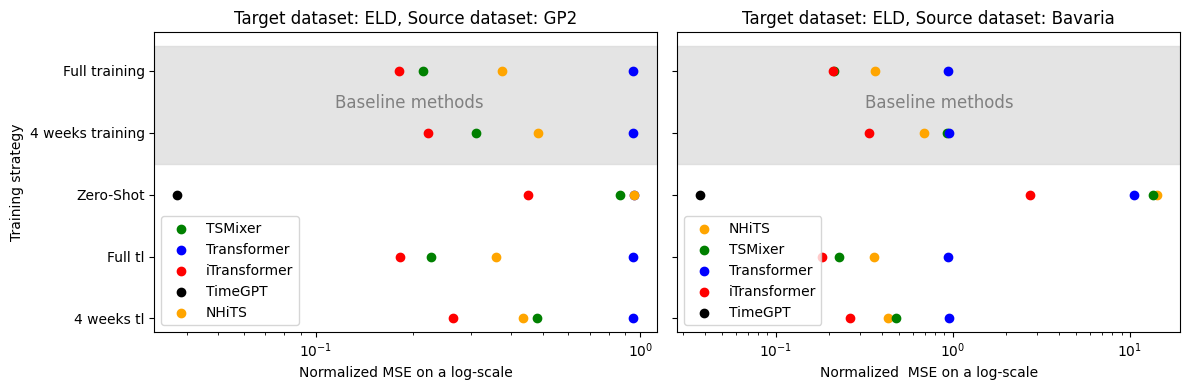

In [191]:
visualize("ELD", 0.115, 0.32)

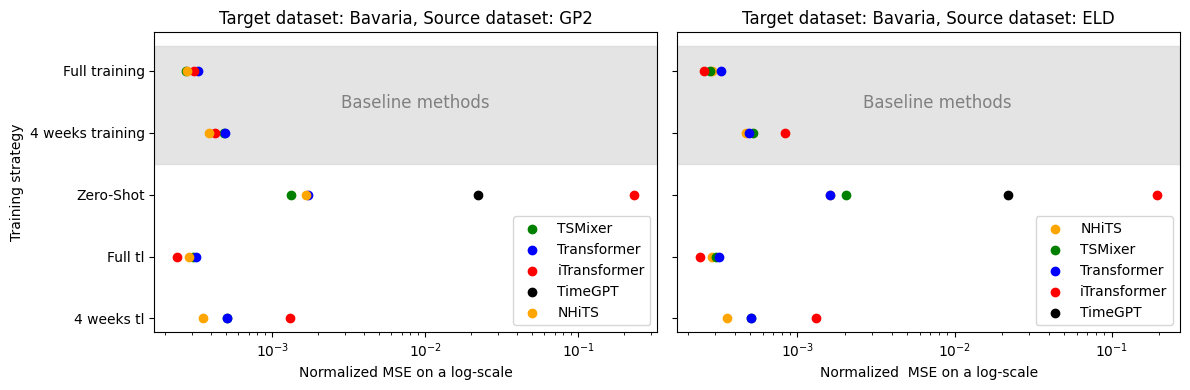

In [193]:
visualize("Bavaria", 0.0028, 0.0026)

# calculate jumpstart & asymptotic performance

#jumpstart_zero_shot = 1 - (four_weeks_train / zero_shot)
#jumpstart_short_tl = 1 - (four_weeks_train / four_weeks_tl)

#asymptotic_perf = 1- (full_train / full_tl) 


was will ich visualisieren?

tl metrics for gp2 -> eld
tl metrics for eld ->gp2

In [188]:
# calc tl metrics for target:eld, source:gp2

def calc_ratio(baseline, metric, name):
    return pd.DataFrame([(baseline / metric -1) * 100], index=[name])


short_train_eld = target_dataset_metrics["ELD_mse"].loc["ELD","four_weeks_training"][:4].values
full_train_eld = target_dataset_metrics["ELD_mse"].loc["ELD","full_training"][:4].values

zero_shot_eld = target_dataset_metrics["ELD_mse"].loc["GP2", "Zero-Shot"][:4].values
short_tl_eld = target_dataset_metrics["ELD_mse"].loc["GP2", "four_weeks_tl"][:4].values
full_tl_eld = target_dataset_metrics["ELD_mse"].loc["GP2", "full_tl"][:4].values

jumpstart_zero_shot = calc_ratio(short_train_eld, zero_shot_eld, "Jumpstart Zero-Shot [%]")
jumpstart_short_tl = calc_ratio(short_train_eld, short_tl_eld, "Jumpstart Short TL [%]")
asymptotic = calc_ratio(full_train_eld, full_tl_eld, "Asymptotic [%]")

eld_metrics = pd.concat([jumpstart_zero_shot, jumpstart_short_tl, asymptotic])
eld_metrics.columns = target_dataset_metrics["ELD_mse"].columns[:4]
eld_metrics["Target"] = "ELD"

# calc tl metrics for target:gp2, source:eld
short_train_gp2 = target_dataset_metrics["GP2_mse"].loc["GP2","four_weeks_training"][:4].values
full_train_gp2 = target_dataset_metrics["GP2_mse"].loc["GP2","full_training"][:4].values

zero_shot_gp2 = target_dataset_metrics["GP2_mse"].loc["ELD", "Zero-Shot"][:4].values
short_tl_gp2 = target_dataset_metrics["GP2_mse"].loc["ELD", "four_weeks_tl"][:4].values
full_tl_gp2 = target_dataset_metrics["GP2_mse"].loc["ELD", "full_tl"][:4].values

jumpstart_zero_shot = calc_ratio(short_train_gp2, zero_shot_gp2, "Jumpstart Zero-Shot [%]")
jumpstart_short_tl = calc_ratio(short_train_gp2, short_tl_gp2, "Jumpstart Short TL [%]")
asymptotic = calc_ratio(full_train_gp2, full_tl_gp2, "Asymptotic [%]")

gp2_metrics = pd.concat([jumpstart_zero_shot, jumpstart_short_tl, asymptotic])
gp2_metrics.columns = target_dataset_metrics["ELD_mse"].columns[:4]
gp2_metrics["Target"] = "GP2"

final = pd.concat([gp2_metrics, eld_metrics])
final = final.reset_index()
final = final.rename(columns={"index" : "TL Metric"})
final = final.set_index(["Target", "TL Metric"])
final.to_csv(output_path / "eld_gp2_tl_metrics.csv")

In [194]:
# target dataset specific TL metrics averaged over all datasets
# not the nicest because range of MSE is quite different
def add_list_element_div_2(list_1, list_2):
    assert len(list_1) == len(list_2), "List must be same length"
    output = [(a + b)/2 for a, b in zip(list_1, list_2)]
    return output

def get_tl_metrics(target_df):
    df = target_dataset_metrics[target_df].reset_index()

    zero_shot_df = df[df['Learning_scenario'] == 'Zero-Shot']
    zero_a = list(zero_shot_df.iloc[0][2:6].values)
    zero_b = list(zero_shot_df.iloc[1][2:6].values)
    zero_shot = add_list_element_div_2(zero_a, zero_b)

    four_weeks_tl = df[df['Learning_scenario'] == 'four_weeks_tl']
    short_a = list(four_weeks_tl.iloc[0][2:6].values)
    short_b = list(four_weeks_tl.iloc[1][2:6].values)
    short_tl = add_list_element_div_2(short_a, short_b)

    full_tl = df[df['Learning_scenario'] == 'full_tl']
    full_a = list(full_tl.iloc[0][2:6].values)
    full_b = list(full_tl.iloc[1][2:6].values)
    full_tl = add_list_element_div_2(full_a, full_b)

    four_weeks_training = df[df['Learning_scenario'] == 'four_weeks_training']
    short_training = list(four_weeks_training.iloc[0][2:6].values)

    full_training = df[df['Learning_scenario'] == 'full_training']
    full_training = list(full_training.iloc[0][2:6].values)

    return [zero_shot, short_tl, full_tl, short_training, full_training]
bavaria = get_tl_metrics("Bavaria_mse")
gp2 = get_tl_metrics("GP2_mse")
eld = get_tl_metrics("ELD_mse")

def merge_lists(list_of_lists):
    # Calculate the number of lists
    num_lists = len(list_of_lists)

    # Calculate the element-wise sum of the lists
    element_wise_sum = [sum(values) for values in zip(*list_of_lists)]

    # Calculate the element-wise average
    element_wise_average = [x / num_lists for x in element_wise_sum]
    return element_wise_average

zero_shot = pd.Series(merge_lists([bavaria[0], gp2[0], eld[0]]), name="Zero-Shot")
short_tl = pd.Series(merge_lists([bavaria[1], gp2[1], eld[1]]), name="Short-TL")
full_tl = pd.Series(merge_lists([bavaria[2], gp2[2], eld[2]]), name="Full-TL")
short_training = pd.Series(merge_lists([bavaria[3], gp2[3], eld[3]]), name="Short training")
full_training = pd.Series(merge_lists([bavaria[4], gp2[4], eld[4]]), name="Full training")

metrics = pd.concat([zero_shot, short_tl, full_tl, short_training, full_training], axis=1)
metrics = metrics.transpose()
metrics.columns = target_dataset_metrics["Bavaria_mse"].columns[:4]

# calc mean for each model
mean_values = metrics.mean()
mean_row = pd.DataFrame([mean_values])
mean_row.index = ['Overall Mean [MSE]']
metrics = pd.concat([metrics, mean_row])

jumpstart_zero_shot = pd.DataFrame([(metrics.loc["Short training"] / metrics.loc["Zero-Shot"] -1) * 100], index=["Mean Jumpstart Zero-Shot"])
jumpstart_tl = pd.DataFrame([(metrics.loc["Short training"] / metrics.loc["Short-TL"] -1) * 100], index= ["Mean Jumpstart TL"])
asymptotic = pd.DataFrame([(metrics.loc["Full training"] / metrics.loc["Full-TL"] -1) * 100], index=["Mean Asymptotic Perf."])

metrics = pd.concat([metrics, jumpstart_zero_shot, jumpstart_tl, asymptotic])
metrics.to_csv(output_path / "avg_mse_tl_metrics_all_experiments.csv")
metrics

#DONE

,NHiTS,Transformer,TSMixer,iTransformer
Zero-Shot,172535.902119,3.384655,3.971310,1.162249
Short-TL,59.620813,0.667614,0.495551,0.278754
Full-TL,0.442325,0.641374,0.288565,0.218561
Short training,1.415731,0.667558,0.511216,0.284257
Full training,0.446657,0.641106,0.300535,0.220028
Overall Mean [MSE],34519.565529,1.200462,1.113435,0.432770
Mean Jumpstart Zero-Shot,-99.999179,-80.276930,-87.127270,-75.542468
Mean Jumpstart TL,-97.625441,-0.008406,3.161214,1.974180
Mean Asymptotic Perf.,0.979518,-0.041694,4.148363,0.671154
